# Data Analysis Part Andrea

Linking number of edit events since last successful build to probability of build succeeding

In [23]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Import cleaned Data


In [2]:
#if cleaned csv available
editEvents = pd.read_csv("data/df_edit.csv")
buildEvents = pd.read_csv("data/df_build.csv")
# else run script ()
#def parse_timestamp(time):
#    if type(time) is str:
#        time = time.split('.')[0]
#        return pd.Timestamp(time)
#buildEvents['timestamp']=buildEvents['timestamp'].apply(parse_timestamp)
#editEvents['timestamp']=editEvents['timestamp'].apply(parse_timestamp)

### Edit Events

In [5]:
print(f'No of edit events: {len(editEvents)}')
editEvents.tail()

No of edit events: 497459


,Unnamed: 0,sessionID,timestamp
497454,258848,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:48
497455,258849,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:52
497456,258850,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:13:58
497457,258851,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:14:03
497458,258852,ffcbdaa4-e264-45a3-bddb-6f2f0afeac2f,2016-04-20 15:14:07


In [8]:
editEvents[["sessionID","timestamp"]].describe()

,sessionID,timestamp
count,497459,497459
unique,2876,488049
top,8d0ea603-57cd-4b1f-b3cf-ce39ec9203c7,2016-09-04 23:28:09
freq,17006,4


### Build Events

In [9]:
print(f'No of build events: {len(buildEvents)}')
buildEvents.head()

No of build events: 14957


,Unnamed: 0,sessionID,timestamp,buildSuccessful
0,14061,0,2016-10-04 14:35:55,False
1,14062,0,2016-10-04 14:36:07,False
2,14063,0,2016-10-04 14:36:50,False
3,14064,0,2016-10-04 14:36:53,False
4,14065,1,2016-10-04 14:37:03,True


In [11]:
buildEvents[["sessionID","timestamp","buildSuccessful"]].describe()

,sessionID,timestamp,buildSuccessful
count,14957,14956,14956
unique,1531,14877,2
top,26f3dadd-c2e3-414b-8c92-78df1dc356c8,2016-04-21 17:41:37,True
freq,154,2,12889


# Process Data

1. Step: For each sessionID:
    - a) get timestamp of the last successfull build
    - b) get timestamp of next build after a)
2. Step: For each session ID:
    - Count number of edit between the two timestamp in Step 1
    - if no buildEvent after last successfull build occurs, dont count
3. Step: Create new DataFrame with following variables:
    - sessionID,timestampSuccessBuild, timestampNextBuild, #editsUntilNextBuild and nextBuildResult

In [12]:
def get_all_build(sessionID):
    all_build = buildEvents[buildEvents["sessionID"] == sessionID]
    return all_build.sort_values(["timestamp"]).values


In [13]:
def get_successful_build(sessionID):
    all_successful_build = buildEvents[(buildEvents["sessionID"] == sessionID) & (buildEvents["buildSuccessful"] == True)] 
    return all_successful_build.sort_values(["timestamp"]).values


In [14]:
def get_nr_edits_between_build(sessionID,timeLastSuccessfullBuild, timeNextBuild):
    totalEdit = editEvents[editEvents["sessionID"] == sessionID]
    totalEdit = totalEdit.sort_values(["timestamp"])
    editBetweenSuccessBuildAndBuild = totalEdit[(totalEdit["timestamp"] <= timeNextBuild) & (totalEdit["timestamp"] >= timeLastSuccessfullBuild)]
    return editBetweenSuccessBuildAndBuild["timestamp"].values.size


In [15]:
def edits_from_pass_to_next_build(sessionID):
    result = []

    # get all successful build of session 
    allSuccessfulBuild = get_successful_build(sessionID)
    allBuild = get_all_build(sessionID)
    numOfSuccessfulBuild = np.size(allSuccessfulBuild,0)
    numOfBuild = np.size(allBuild,0)
    # iterate over each passed build
    for s in range(numOfSuccessfulBuild):
        # if build follows, count edits
        if allBuild[-1][2]>allSuccessfulBuild[s][2]:
            for b in range(numOfBuild):
                if allBuild[b][2]>allSuccessfulBuild[s][2]:
                    break
            timeLastSuccessfulBuild=allSuccessfulBuild[s][2]
            timeNextBuild=allBuild[b][2]
            resultNextBuild=allBuild[b][3]
            nrOfEdit=get_nr_edits_between_build(sessionID,timeLastSuccessfulBuild, timeNextBuild)
            sessionID = allBuild[b][1]
            
            result.append([sessionID, timeLastSuccessfulBuild, timeNextBuild, nrOfEdit, resultNextBuild])
            
    return result

### Iterate over all sessions and create DataFrame

In [16]:
final_result=[]
allSessionID=buildEvents.sessionID.unique()
print(f'time before loop: {datetime.now(tz=None)} \n')
# get edits_from_pass_to_next_build for all sessionID
for sessionID in allSessionID:
    Observations = edits_from_pass_to_next_build(sessionID)
    NrOfObservations = len(Observations)
    # take only sessionID with at least 1 successful build and at least 1 build after that  
    if NrOfObservations > 0:
        for Obs in Observations:
            final_result.append(Obs)
print(f'time after loop: {datetime.now(tz=None)} \n')

time before loop: 2020-05-11 11:16:52.878853 

time after loop: 2020-05-11 11:23:22.725436 



In [12]:
final_array=[]
final_result=[]
allSessionID=buildEvents.sessionID.unique()
print(f'time before loop: {datetime.now(tz=None)} \n')
# get edits_from_pass_to_next_build for all sessionID
for sessionID in allSessionID:
    final_array.append(edits_from_pass_to_next_build(sessionID))
    
# take only sessionID with at least 1 successful build and at 1 build after that  
for Observation in range(len(allSessionID)):
    if len(final_array[Observation]) > 0:
           for NOO in range(len(final_array[Observation])):
                                final_result.append(final_array[Observation][NOO])

print(f'time after loop: {datetime.now(tz=None)} \n')

time before loop: 2020-04-14 16:39:44.468191 

time after loop: 2020-04-14 16:46:21.041335 



In [18]:
#create DataFrame
column_labels = ['sessionID','timestampSuccessBuild','timestampNextBuild', '#editsUntilNextBuild', 'nextBuildResult']
df = pd.DataFrame(final_result, columns=column_labels)
df

,sessionID,timestampSuccessBuild,timestampNextBuild,#editsUntilNextBuild,nextBuildResult
0,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 09:27:01,2016-11-10 10:22:32,5,True
1,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 10:22:32,2016-11-10 10:58:26,16,True
2,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 10:58:26,2016-11-10 11:07:58,18,True
3,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 11:07:58,2016-11-10 11:37:53,38,True
4,00479c7a-a779-4b46-b6e7-e421eabeddf3,2016-11-10 11:37:53,2016-11-10 11:41:29,8,True
...,...,...,...,...,...
11584,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:53:44,2016-06-14 14:57:24,6,True
11585,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 14:57:24,2016-06-14 15:04:17,39,True
11586,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:04:17,2016-06-14 15:05:05,3,True
11587,ffc444d0-8382-4e52-9f04-3c42601ec739,2016-06-14 15:05:05,2016-06-14 15:23:53,43,True


## Build a Model

In [14]:
#TODO: probability of successful build given number of edits after last successful build

In [61]:
from statsmodels.discrete.discrete_model import Probit
import statsmodels.tools.tools as sm
import seaborn as sns

In [19]:
df.isnull().any()

sessionID                False
timestampSuccessBuild    False
timestampNextBuild       False
#editsUntilNextBuild     False
nextBuildResult          False
dtype: bool

In [72]:
df.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","max"]})

#editsUntilNextBuild                 
                               count       mean   max
nextBuildResult                                      
False                            710  43.074648  3838
True                           10879  18.572663  2330

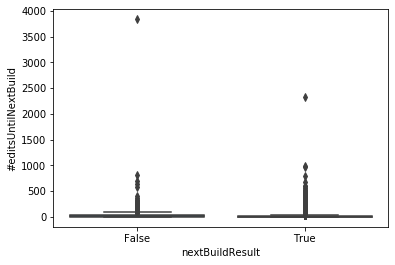

In [64]:
sns.boxplot(x=df["nextBuildResult"], y=df["#editsUntilNextBuild"])

In [68]:
df1=df.loc[(df["#editsUntilNextBuild"]>0) & (df["#editsUntilNextBuild"]<200)]

In [76]:
df1.groupby("nextBuildResult").agg({"#editsUntilNextBuild":["count","mean","max"]})

#editsUntilNextBuild                
                               count       mean  max
nextBuildResult                                     
False                            686  27.360058  198
True                           10755  15.428266  199

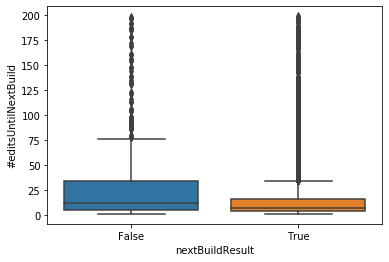

In [69]:
sns.boxplot(x=df1["nextBuildResult"], y=df1["#editsUntilNextBuild"])

(0, 1000)

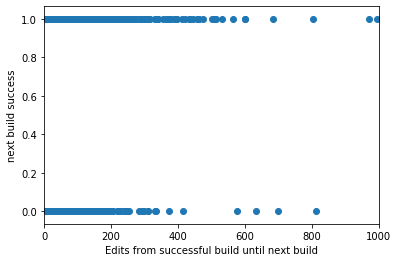

In [74]:
plt.scatter(df["#editsUntilNextBuild"],df["nextBuildResult"])
plt.xlabel("Edits from successful build until next build")
plt.ylabel("next build success")
plt.xlim(0,1000)

In [75]:
Y = df1["nextBuildResult"]
X = df1["#editsUntilNextBuild"]
X = sm.add_constant(X)
model = Probit(Y, X.astype(float))
probit_model = model.fit()
print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.221993
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:        nextBuildResult   No. Observations:                11441
Model:                         Probit   Df Residuals:                    11439
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 May 2020   Pseudo R-squ.:                 0.02144
Time:                        16:48:52   Log-Likelihood:                -2539.8
converged:                       True   LL-Null:                       -2595.5
Covariance Type:            nonrobust   LLR p-value:                 5.127e-26
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.6828      0.023     74.089      0.000       1.638       1.727